In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 08
### Neural Network with Pytorch :
- One hidden layer 
- ${Tanh}$ activation function
- **multi-class**

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline

2023-11-24 12:16:34.076457: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 12:16:34.079100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 12:16:34.115248: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 12:16:34.115278: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 12:16:34.115300: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
# gpus=tf.config.list_physical_devices('GPU')
# try:
#     for g in gpus:
#         tf.config.experimental.set_meomry_growth(g,True)
#     logical_gpus=tf.config.list_logical_devices
#     print(len(gpus),'Physical gpus',len(logical_gpus),'Logical gpus')
# except:
#     print('Invalid Devices')

In [4]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 10001 # number of epochs
ALPHA = 0.001 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Helper Functions

In [5]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], 
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns 
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], 
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )


## Generate Data Set
<p style="font-family: Arial; font-size:1.1em;color:blue;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [6]:
data_df=pd.read_csv('fifa_2019.csv')

In [7]:
data_df

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,19,https://cdn.sofifa.org/players/4/19/238813.png,England,https://cdn.sofifa.org/flags/14.png,47,65,Crewe Alexandra,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,18203,243165,N. Christoffersson,19,https://cdn.sofifa.org/players/4/19/243165.png,Sweden,https://cdn.sofifa.org/flags/46.png,47,63,Trelleborgs FF,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,18204,241638,B. Worman,16,https://cdn.sofifa.org/players/4/19/241638.png,England,https://cdn.sofifa.org/flags/14.png,47,67,Cambridge United,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,18205,246268,D. Walker-Rice,17,https://cdn.sofifa.org/players/4/19/246268.png,England,https://cdn.sofifa.org/flags/14.png,47,66,Tranmere Rovers,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


In [8]:
for col in data_df.columns:
    print (f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [9]:
data_df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [10]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64

In [11]:
data_df = data_df[data_df['Position'].notnull()]
data_df.shape

(18147, 89)

In [12]:
rel_columns = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes',]

"""['Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
          'Release Clause'],
      dtype='object']"""

"['Name', 'Age', 'Photo', 'Nationality', 'Flag',\n       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',\n       'Preferred Foot', 'International Reputation', 'Weak Foot',\n       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', \n       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',\n       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',\n       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',\n       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',\n          'Release Clause'],\n      dtype='object']"

In [13]:
data_df = data_df[rel_columns]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [14]:
data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [15]:
data_df.Position.unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [16]:
goalkeeper = 'GK'

forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS', 'LS', 'CF']

midfielders = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']

defence = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [17]:
data_df.loc[data_df['Position'] == 'GK', 'Position'] = 0

data_df.loc[data_df['Position'].isin(defence) ,     'Position'] = 1

data_df.loc[data_df['Position'].isin(midfielders) , 'Position'] = 2

data_df.loc[data_df['Position'].isin(forward) ,     'Position'] = 3

data_df['Position'] = pd.to_numeric(data_df['Position'], downcast='integer')

In [18]:
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [19]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [20]:
labels = { 0 : 'Goal Keepers', 1 : 'Defence', 2 : 'Mid-fielders', 3 : 'Forward'}

In [21]:
features_df = data_df.drop('Position', axis= 1) # drop label col

label_df  = data_df['Position'] #labels

features_df.shape, label_df.shape

((18147, 33), (18147,))

In [22]:
label_df = pd.get_dummies(label_df)
label_df.head()

,0,1,2,3
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,True,False,False,False
4,False,False,True,False


In [23]:
features_df

,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,...,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0
18203,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,...,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0
18204,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,...,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0
18205,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,...,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(features_df, label_df, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                   stratify=label_df)



In [25]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) #train
X_test = scaler.transform(X_test) #test


y_train = y_train.to_numpy() # array
y_test = y_test.to_numpy()  #convert to array

In [26]:
label_df = pd.get_dummies(label_df)
label_df.shape

(18147, 4)

In [27]:
label_df.head()

,0,1,2,3
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,True,False,False,False
4,False,False,True,False


In [28]:
torch.version.cuda

'12.1'

In [29]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [30]:
class Model(nn.Module):
    def __init__(self,input_dim):
        super (Model,self).__init__()
        self.layer1=nn.Linear(input_dim,18)
        self.layer2=nn.Linear(18,4)
        
    def forward(self,x):
        
        x=F.tanh(self.layer1(x))
        
        x=F.softmax(self.layer2(x),dim=1)
        
        return x

In [31]:
# model=Model(X_train.shape[1]).to(device)
# model

In [32]:
model = nn.Sequential(
    nn.Linear(33,18),
          nn.Tanh(),
          nn.Linear(18,4),
    nn.Softmax(dim=1)
)

In [33]:
model

Sequential(
  (0): Linear(in_features=33, out_features=18, bias=True)
  (1): Tanh()
  (2): Linear(in_features=18, out_features=4, bias=True)
  (3): Softmax(dim=1)
)

In [34]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0505, -0.1313, -0.1209,  0.0240,  0.1521,  0.0112, -0.0863, -0.1399,
          -0.1234,  0.1212,  0.0027,  0.0488, -0.0228, -0.0395,  0.1530, -0.0347,
           0.1672, -0.1106, -0.0321,  0.0017,  0.0595,  0.0292, -0.0483, -0.0624,
          -0.0481, -0.1670, -0.1341,  0.1469,  0.1467,  0.0096, -0.1585,  0.1136,
          -0.1219],
         [-0.1093, -0.0243, -0.0756, -0.1579,  0.0638, -0.0638, -0.0531,  0.0522,
          -0.0231, -0.0961,  0.1396,  0.0014,  0.0880, -0.0103, -0.1215, -0.1614,
           0.1296,  0.1668,  0.0468,  0.0075, -0.0994, -0.0393,  0.0145,  0.0774,
          -0.1088,  0.0844, -0.0879, -0.0590,  0.0026, -0.1437,  0.1016, -0.1196,
           0.0450],
         [ 0.1163, -0.0593, -0.0714,  0.0948,  0.0240, -0.1552, -0.0695, -0.0944,
           0.1253, -0.0008, -0.1338,  0.1098, -0.0720,  0.0628, -0.1710,  0.0402,
           0.1642, -0.0228, -0.0953,  0.1166,  0.0274, -0.1124, -0.1682,  0.1218,
          -0.0950, -0.0708,  0.0839

In [35]:
print(f'Number of parameters',len(list(model.parameters())))

Number of parameters 4


In [36]:
print(f'Layer 1 weights : {list(model.parameters())[0].shape}')
print(f'Layer 1 bias : {list(model.parameters())[1].shape}')
print(f'Layer 2 weights : {list(model.parameters())[2].shape}')
print(f'Layer 2 bias : {list(model.parameters())[3].shape}')

Layer 1 weights : torch.Size([18, 33])
Layer 1 bias : torch.Size([18])
Layer 2 weights : torch.Size([4, 18])
Layer 2 bias : torch.Size([4])


In [37]:
train_X=Variable(torch.Tensor(X_train)).to(device)
train_y=Variable(torch.Tensor(y_train)).to(device)
test_X=Variable(torch.Tensor(X_test)).to(device)
test_y=Variable(torch.Tensor(y_test)).to(device)

In [38]:
loss_fn = nn.CrossEntropyLoss()

loss=[]
tloss=[]
n_epoch=[]
acc=[]
tacc=[]

optimizer = torch.optim.Adam(model.parameters(),lr=ALPHA)  #Optimizer

# Iterations
for epoch in range(EPOCHS):
    model.train()    #Set the model
    predict_prob = model(train_X)
    curr_loss = loss_fn(predict_prob,train_y)
   
    ###-----------------
    ### BACK PROPAGATION
    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()
    ###-----------------
   
    loss.append(curr_loss.data.item())
    _,y_pred = torch.max(predict_prob,1)
    curr_acc = accuracy_score(y_train.argmax(axis=1),y_pred.data.cpu())
    acc.append(curr_acc)
   
    model.eval()
   
    pred_prob_tst = model(test_X)
    tcurr_loss = loss_fn(pred_prob_tst,test_y)
    tloss.append(tcurr_loss.data.item())
    _,y_pred = torch.max(pred_prob_tst,1)
    curr_acc_ts = accuracy_score(y_test.argmax(axis=1),y_pred.data.cpu())
    tacc.append(curr_acc_ts)
   
    n_epoch.append(epoch)

    if epoch%100==0:
        print(f'epoch:{epoch} --- Loss{curr_loss.data.item():.3f}/{tcurr_loss.data.item():.3f}', end = '')
        print(f'--- Acc {curr_acc:.3f}/{curr_acc_ts:.3f}')

epoch:0 --- Loss1.351/1.346--- Acc 0.496/0.517
epoch:100 --- Loss1.045/1.044--- Acc 0.780/0.780
epoch:200 --- Loss0.944/0.944--- Acc 0.832/0.829
epoch:300 --- Loss0.912/0.912--- Acc 0.853/0.847
epoch:400 --- Loss0.895/0.896--- Acc 0.864/0.860
epoch:500 --- Loss0.886/0.887--- Acc 0.869/0.867
epoch:600 --- Loss0.881/0.882--- Acc 0.873/0.867
epoch:700 --- Loss0.877/0.879--- Acc 0.874/0.868
epoch:800 --- Loss0.874/0.876--- Acc 0.876/0.870
epoch:900 --- Loss0.872/0.874--- Acc 0.876/0.872
epoch:1000 --- Loss0.870/0.872--- Acc 0.877/0.875
epoch:1100 --- Loss0.868/0.870--- Acc 0.879/0.875
epoch:1200 --- Loss0.867/0.869--- Acc 0.881/0.877
epoch:1300 --- Loss0.866/0.868--- Acc 0.882/0.877
epoch:1400 --- Loss0.864/0.867--- Acc 0.883/0.879
epoch:1500 --- Loss0.863/0.866--- Acc 0.885/0.882
epoch:1600 --- Loss0.862/0.865--- Acc 0.886/0.882
epoch:1700 --- Loss0.861/0.864--- Acc 0.887/0.882
epoch:1800 --- Loss0.860/0.864--- Acc 0.888/0.883
epoch:1900 --- Loss0.859/0.863--- Acc 0.889/0.885
epoch:2000 -

In [39]:
loss_df = pd.DataFrame({'epoch' : n_epoch,
                       'loss' : loss,
                       'test loss' : tloss,
                       'acc' : acc,
                       'test acc' : tacc})

In [40]:
loss_df.head()

,epoch,loss,test loss,acc,test acc
0,0,1.351009,1.346040,0.495764,0.516529
1,1,1.345419,1.340427,0.520975,0.537466
2,2,1.339821,1.334825,0.541090,0.552893
3,3,1.334233,1.329251,0.557760,0.565565
4,4,1.328677,1.323725,0.569264,0.573554


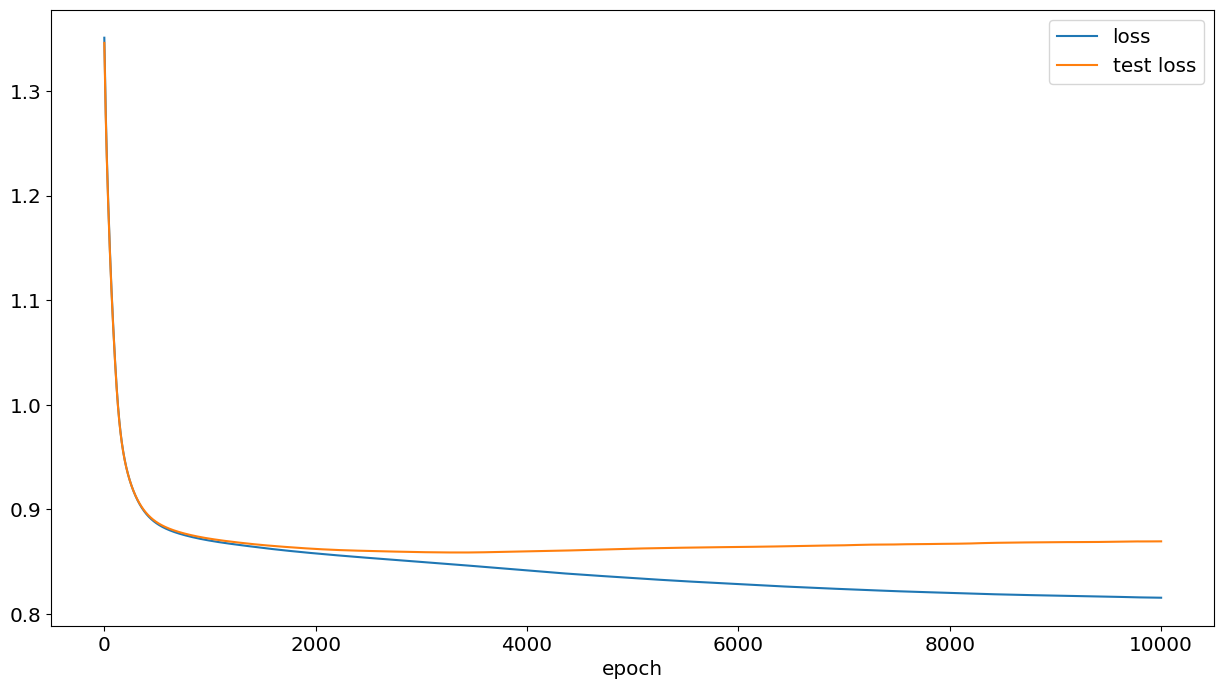

In [45]:
loss_df.plot(x='epoch',y=['loss','test loss']);

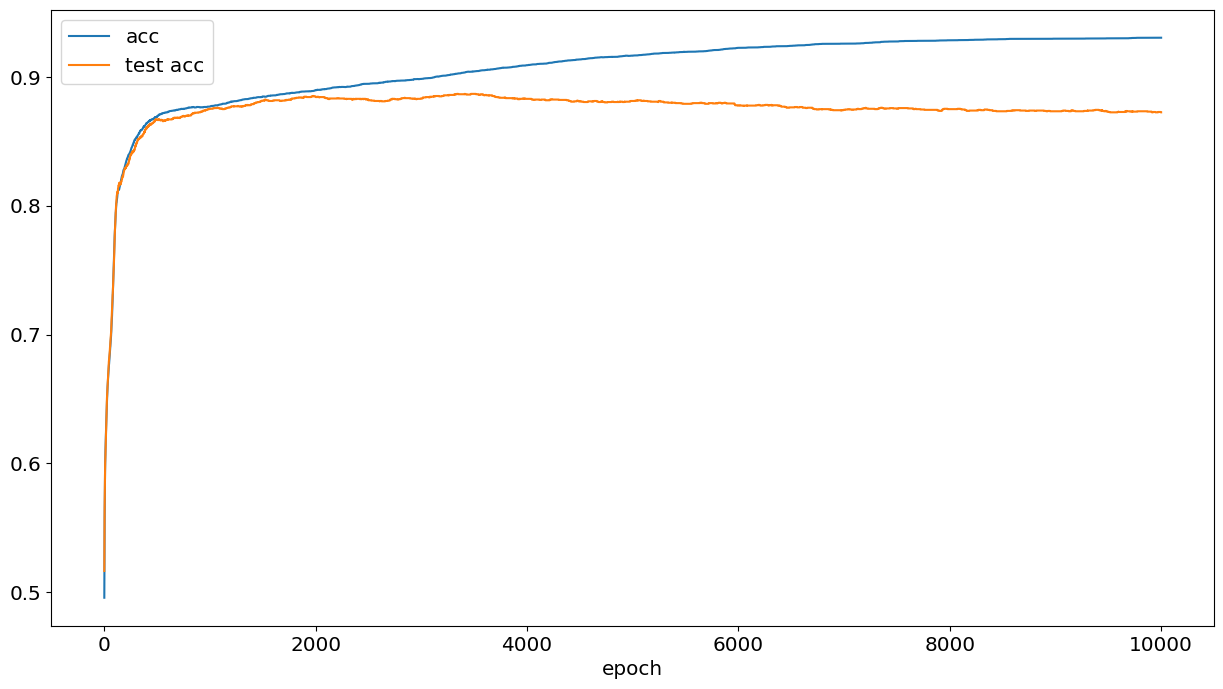

In [44]:
loss_df.plot(x='epoch',y=['acc','test acc']);